In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, log_loss
)
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('../SnP_daily_update_AMZN_features_with_target.csv')

# Load feature list from AMZN_methods_all_in_one.csv
feature_df = pd.read_csv('../AMZN_methods_all_in_one.csv')
features = feature_df['feature'].tolist()
print("Features used:", features)
print("Target: y_ret_t1")

Features used: ['lower_wick', 'vol_chg', 'ma_gap_20', 'vol_ratio_20', 'ret_1', 'upper_wick', 'co_ret', 'range_pct', 'ret_2', 'vol_10', 'ret_5', 'vol_20', 'ret_4', 'ma_gap_10', 'ret_3']
Target: y_ret_t1


In [20]:
# Prepare X and y
X = data[features].copy()
y = data['y_ret_t1'].copy()

# Drop rows with NaN
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Train-test split (time-series: no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")

Dataset shape: X=(4028, 15), y=(4028,)
Train: 3222 samples | Test: 806 samples


In [21]:
# Scale features and apply Polynomial Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print(f"Polynomial features shape: {X_train_poly.shape[1]} features (from {X_train_scaled.shape[1]} original)")

# ===== sklearn Polynomial Regression =====
model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred_train = model.predict(X_train_poly)
y_pred_test = model.predict(X_test_poly)
print("sklearn model trained successfully!")

# ===== Polynomial Regression FROM SCRATCH (Normal Equation) =====
class PolynomialRegressionScratch:
    def __init__(self, degree=2):
        self.degree = degree
        self.weights = None
        self.mean = None
        self.std = None

    def _standardize(self, X, fit=False):
        if fit:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            self.std[self.std == 0] = 1
        return (X - self.mean) / self.std

    def _polynomial_features(self, X):
        n_samples, n_features = X.shape
        features_list = [X]
        if self.degree >= 2:
            poly_feats = []
            for i in range(n_features):
                for j in range(i, n_features):
                    poly_feats.append((X[:, i] * X[:, j]).reshape(-1, 1))
            features_list.append(np.hstack(poly_feats))
        return np.hstack(features_list)

    def _add_bias(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64).ravel()
        X_scaled = self._standardize(X, fit=True)
        X_poly = self._polynomial_features(X_scaled)
        X_bias = self._add_bias(X_poly)
        lambda_reg = 1e-8
        I = np.eye(X_bias.shape[1])
        I[0, 0] = 0
        self.weights = np.linalg.solve(X_bias.T @ X_bias + lambda_reg * I, X_bias.T @ y)
        self.n_features_poly_ = X_poly.shape[1]
        return self

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        X_scaled = self._standardize(X, fit=False)
        X_poly = self._polynomial_features(X_scaled)
        X_bias = self._add_bias(X_poly)
        return X_bias @ self.weights

scratch_model = PolynomialRegressionScratch(degree=2)
scratch_model.fit(X_train.values, y_train.values)
y_pred_train_scratch = scratch_model.predict(X_train.values)
y_pred_test_scratch = scratch_model.predict(X_test.values)
print(f"From-scratch model trained successfully! (features: {scratch_model.n_features_poly_})")

Polynomial features shape: 135 features (from 15 original)
sklearn model trained successfully!
From-scratch model trained successfully! (features: 135)


In [22]:
# ==================== REGRESSION METRICS COMPARISON ====================

# sklearn metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

# From-scratch metrics
mse_train_s = np.mean((y_train.values - y_pred_train_scratch) ** 2)
mse_test_s  = np.mean((y_test.values  - y_pred_test_scratch) ** 2)
rmse_train_s = np.sqrt(mse_train_s)
rmse_test_s  = np.sqrt(mse_test_s)
mae_train_s = np.mean(np.abs(y_train.values - y_pred_train_scratch))
mae_test_s  = np.mean(np.abs(y_test.values  - y_pred_test_scratch))
ss_res_train = np.sum((y_train.values - y_pred_train_scratch) ** 2)
ss_tot_train = np.sum((y_train.values - np.mean(y_train.values)) ** 2)
r2_train_s = 1 - ss_res_train / ss_tot_train
ss_res_test = np.sum((y_test.values - y_pred_test_scratch) ** 2)
ss_tot_test = np.sum((y_test.values - np.mean(y_test.values)) ** 2)
r2_test_s = 1 - ss_res_test / ss_tot_test

print("=" * 75)
print("     REGRESSION METRICS: sklearn vs From Scratch")
print("=" * 75)
print(f"{'Metric':<10} {'sklearn Train':>14} {'Scratch Train':>14} {'sklearn Test':>14} {'Scratch Test':>14}")
print("-" * 75)
print(f"{'MSE':<10} {mse_train:>14.6f} {mse_train_s:>14.6f} {mse_test:>14.6f} {mse_test_s:>14.6f}")
print(f"{'RMSE':<10} {rmse_train:>14.6f} {rmse_train_s:>14.6f} {rmse_test:>14.6f} {rmse_test_s:>14.6f}")
print(f"{'MAE':<10} {mae_train:>14.6f} {mae_train_s:>14.6f} {mae_test:>14.6f} {mae_test_s:>14.6f}")
print(f"{'R²':<10} {r2_train:>14.6f} {r2_train_s:>14.6f} {r2_test:>14.6f} {r2_test_s:>14.6f}")

     REGRESSION METRICS: sklearn vs From Scratch
Metric      sklearn Train  Scratch Train   sklearn Test   Scratch Test
---------------------------------------------------------------------------
MSE              0.000391       0.000391       0.000459       0.000459
RMSE             0.019765       0.019765       0.021414       0.021414
MAE              0.014027       0.014027       0.015317       0.015317
R²               0.096756       0.096756      -0.121247      -0.121247


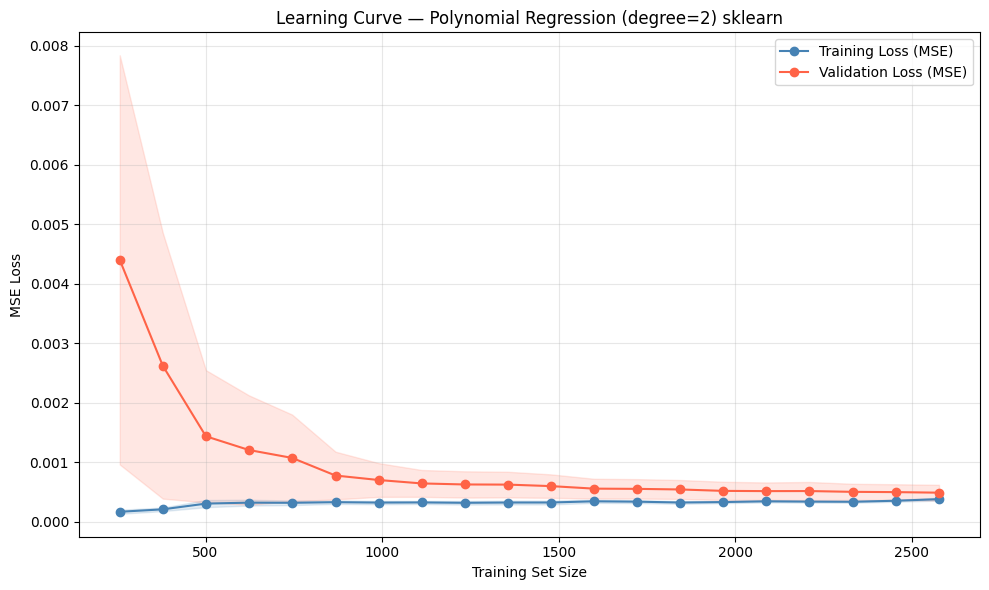

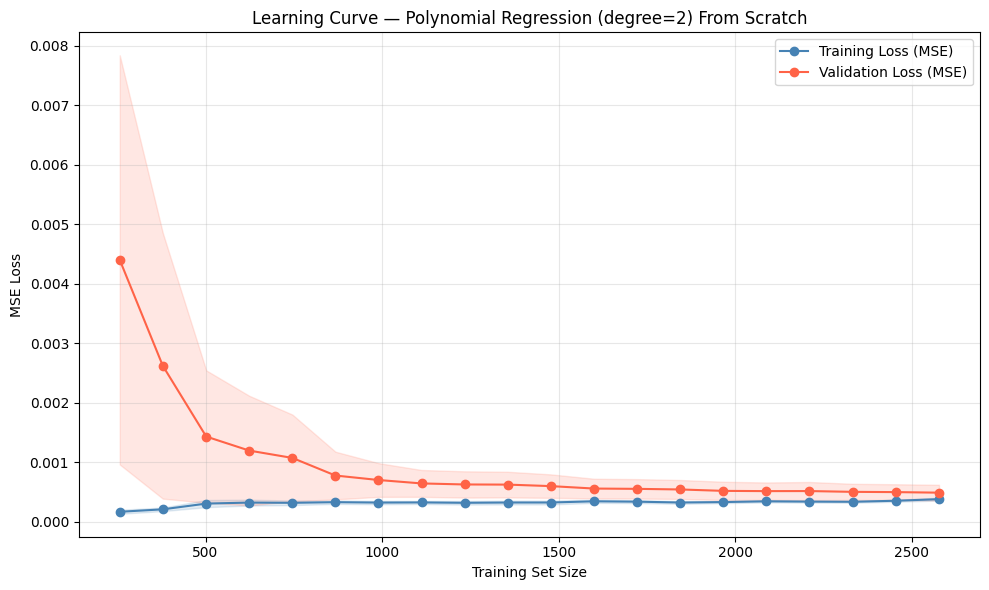

In [26]:
# ==================== Learning Curve (Loss Graph) ====================
from sklearn.model_selection import learning_curve

# ==================== From sklearn ====================
train_sizes, train_scores_mse, test_scores_mse = learning_curve(
    LinearRegression(),
    X_train_poly, y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=5,
    scoring='neg_mean_squared_error',
    shuffle=False,
    n_jobs=-1
)

train_loss = -train_scores_mse.mean(axis=1)
test_loss = -test_scores_mse.mean(axis=1)
train_loss_std = train_scores_mse.std(axis=1)
test_loss_std = test_scores_mse.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss, 'o-', color='steelblue', label='Training Loss (MSE)')
plt.fill_between(train_sizes, train_loss - train_loss_std, train_loss + train_loss_std, alpha=0.15, color='steelblue')
plt.plot(train_sizes, test_loss, 'o-', color='tomato', label='Validation Loss (MSE)')
plt.fill_between(train_sizes, test_loss - test_loss_std, test_loss + test_loss_std, alpha=0.15, color='tomato')
plt.xlabel('Training Set Size')
plt.ylabel('MSE Loss')
plt.title('Learning Curve — Polynomial Regression (degree=2) sklearn')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==================== From Scratch ====================
from sklearn.model_selection import KFold

scratch_train_sizes_frac = np.linspace(0.1, 1.0, 20)
n_train = X_train.shape[0]
kf = KFold(n_splits=5, shuffle=False)

scratch_train_sizes_out = []
scratch_train_losses = []
scratch_val_losses = []

for frac in scratch_train_sizes_frac:
    fold_train_losses = []
    fold_val_losses = []
    for train_idx, val_idx in kf.split(X_train):
        # Subsample training fold
        sub_size = max(1, int(len(train_idx) * frac))
        sub_train_idx = train_idx[:sub_size]

        X_fold_train = X_train.values[sub_train_idx]
        y_fold_train = y_train.values[sub_train_idx]
        X_fold_val = X_train.values[val_idx]
        y_fold_val = y_train.values[val_idx]

        m = PolynomialRegressionScratch(degree=2)
        m.fit(X_fold_train, y_fold_train)

        pred_train = m.predict(X_fold_train)
        pred_val = m.predict(X_fold_val)

        fold_train_losses.append(np.mean((y_fold_train - pred_train) ** 2))
        fold_val_losses.append(np.mean((y_fold_val - pred_val) ** 2))

    scratch_train_sizes_out.append(int(len(train_idx) * frac))
    scratch_train_losses.append(fold_train_losses)
    scratch_val_losses.append(fold_val_losses)

scratch_train_sizes_out = np.array(scratch_train_sizes_out)
scratch_train_loss_mean = np.array([np.mean(x) for x in scratch_train_losses])
scratch_val_loss_mean = np.array([np.mean(x) for x in scratch_val_losses])
scratch_train_loss_std = np.array([np.std(x) for x in scratch_train_losses])
scratch_val_loss_std = np.array([np.std(x) for x in scratch_val_losses])

plt.figure(figsize=(10, 6))
plt.plot(scratch_train_sizes_out, scratch_train_loss_mean, 'o-', color='steelblue', label='Training Loss (MSE)')
plt.fill_between(scratch_train_sizes_out,
                 scratch_train_loss_mean - scratch_train_loss_std,
                 scratch_train_loss_mean + scratch_train_loss_std, alpha=0.15, color='steelblue')
plt.plot(scratch_train_sizes_out, scratch_val_loss_mean, 'o-', color='tomato', label='Validation Loss (MSE)')
plt.fill_between(scratch_train_sizes_out,
                 scratch_val_loss_mean - scratch_val_loss_std,
                 scratch_val_loss_mean + scratch_val_loss_std, alpha=0.15, color='tomato')
plt.xlabel('Training Set Size')
plt.ylabel('MSE Loss')
plt.title('Learning Curve — Polynomial Regression (degree=2) From Scratch')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

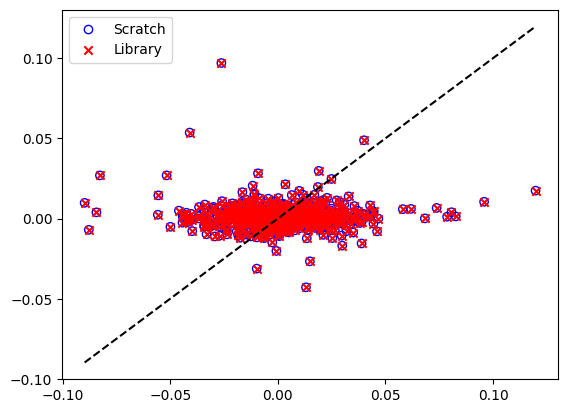

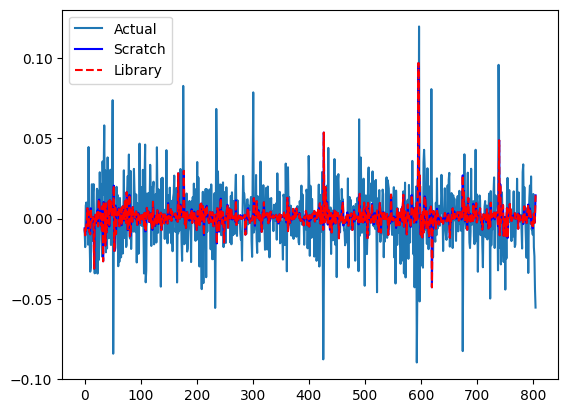

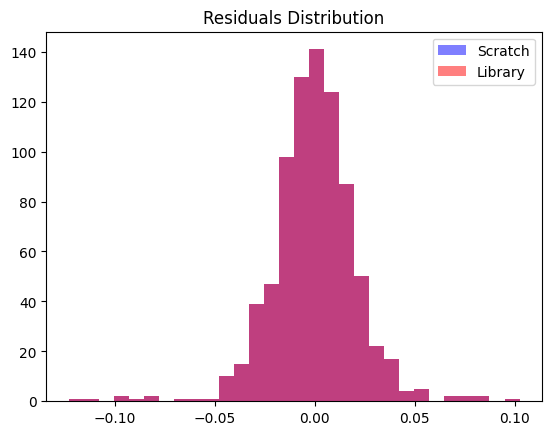

In [48]:
# ==================== COMPARISON PLOTS ====================
plt.scatter(y_test, y_pred_test_scratch,
            marker='o', facecolors='none',
            edgecolors='blue', label='Scratch')

plt.scatter(y_test, y_pred_test,
            marker='x', color='red',
            label='Library')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--')
plt.legend()
plt.show()

plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_test_scratch,
         color='blue', linestyle='-',
         label='Scratch')

plt.plot(y_pred_test,
         color='red', linestyle='--',
         label='Library')
plt.legend()
plt.show()

res_scratch = y_test - y_pred_test_scratch
res_lib = y_test - y_pred_test

plt.hist(res_scratch,color='blue', alpha=0.5, bins=30, label="Scratch")
plt.hist(res_lib, color='red', alpha=0.5, bins=30, label="Library")
plt.legend()
plt.title("Residuals Distribution")
plt.show()